<a href="https://colab.research.google.com/github/Mingrui-Wang/Inverse-of-a-Matrix/blob/master/CAE_7_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/暑期科研/"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['chromosome_l_x_train.npy',
 'chromosome_l_x_test.npy',
 'chromosome_l_y_test.npy',
 'chromosome_l_y_train.npy',
 'chromosome_r_y_test.npy',
 'chromosome_r_y_train.npy',
 'chromosome_r_x_test.npy',
 'chromosome_r_x_train.npy',
 'chromosome_1.npy',
 'chromosome_标签_1.npy',
 '9total_y.npy',
 '9total_x.npy',
 'my_model.h5']

In [2]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
import os

x_train_savepath = './9total_x.npy'
y_train_savepath = './9total_y.npy'

x_test_savepath = './chromosome_1.npy'
y_test_savepath = './chromosome_标签_1.npy'
print('-------------Load Datasets-----------------')
x_train_save = np.load(x_train_savepath)
y_train = np.load(y_train_savepath)
x_test_save = np.load(x_test_savepath)
y_test = np.load(y_test_savepath)
x_train = np.reshape(x_train_save, (len(x_train_save), 150, 150,1))
x_test = np.reshape(x_test_save, (len(x_test_save), 150, 150,1))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
#

class Autoencoder():
    def __init__(self):

        self.img_shape = (150,150,1)

        optimizer = Adam(lr=0.001)

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.autoencoder_model.summary()

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = MaxPooling2D((3, 3), padding='same')(h)

        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((3, 3))(h)
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)

        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

        return Model(input_layer, output_layer)

    def train_model(self, x_train, y_train, x_test, y_test, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1,
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, x_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_test, x_test),
                                             callbacks=[early_stopping])
        
        file = self.autoencoder_model.save_weights('my_model.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


Using TensorFlow backend.


-------------Load Datasets-----------------
(2352, 150, 150, 1)
(1994, 150, 150, 1)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 75, 75, 64)        0   

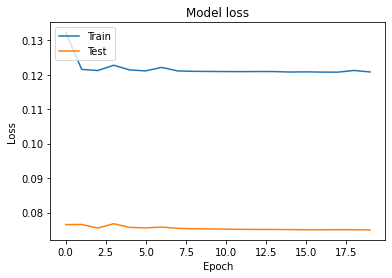

In [3]:
ae = Autoencoder()
ae.train_model(x_train, x_train, x_test, x_test, epochs=20, batch_size=4)

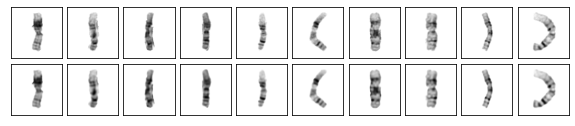

In [4]:
decoded_test = ae.eval_model(x_test)

import matplotlib.pyplot as plt
%matplotlib inline
shape = (150, 150)
fig, axes = plt.subplots(2,10,
                         figsize=(10, 2),
                         subplot_kw={
                             'xticks': [],
                             'yticks': []
                         },
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    axes[0][i].imshow(np.reshape(x_test[i], shape),cmap='gray')
    axes[1][i].imshow(np.reshape(decoded_test[i], shape),cmap='gray')
plt.show()

In [5]:
### get the error term of all testing dataset images
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_test = scaler.fit_transform(x_test.reshape(-1,22500))
#scale it
scaled_output_test = scaler.fit_transform(decoded_test.reshape(-1,22500))

In [6]:
### get the error term of all training set images

# Firstly, we get the decoder image of training set.
decoded_train = ae.eval_model(x_train)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
#scale it
scaled_input_train = scaler.fit_transform(x_train.reshape(-1,22500))
#scale it
scaled_output_train = scaler.fit_transform(decoded_train.reshape(-1,22500))

In [7]:
import pandas as pd
num = len(x_train)+len(x_test)
sequences = range(1,num+1)

In [8]:
from keras import losses
x = losses.mean_squared_error(scaled_input_train,scaled_output_train)
y = losses.mse(scaled_input_test,scaled_output_test)

In [9]:
seqs_ds = pd.DataFrame(sequences)
mse = np.append(x,y)
seqs_ds['binary_crossentropy'] = mse
seqs_ds

,0,binary_crossentropy
0,1,0.169693
1,2,0.169719
2,3,0.169716
3,4,0.169666
4,5,0.169013
...,...,...
4341,4342,0.200099
4342,4343,0.197345
4343,4344,0.199977
4344,4345,0.201036


In [10]:
threshold = len(x_train)/(len(x_train)+len(x_test))
binary_crossentropy_threshold = np.quantile(seqs_ds['binary_crossentropy'], threshold)
print(f'binary_crossentropy 0.84 threshold:{binary_crossentropy_threshold}')

binary_crossentropy 0.84 threshold:0.17266367892899703


In [11]:
seqs_ds['binary_crossentropy_Outlier'] = 0
seqs_ds.loc[seqs_ds['binary_crossentropy'] > binary_crossentropy_threshold, 'binary_crossentropy_Outlier'] = 1

In [12]:
print(f"Num of binary_crossentropy outlier:{seqs_ds['binary_crossentropy_Outlier'].sum()}")

seqs_ds[seqs_ds['binary_crossentropy_Outlier']==1]

Num of binary_crossentropy outlier:1994


,0,binary_crossentropy,binary_crossentropy_Outlier
2352,2353,0.199667,1
2353,2354,0.199326,1
2354,2355,0.200231,1
2355,2356,0.200713,1
2356,2357,0.202539,1
...,...,...,...
4341,4342,0.200099,1
4342,4343,0.197345,1
4343,4344,0.199977,1
4344,4345,0.201036,1


In [13]:
really_outlier = seqs_ds[len(x_train):(len(x_train)+len(x_test)+1)]
correct_outlier_num = len(really_outlier[really_outlier['binary_crossentropy_Outlier']==1])
accuacy = correct_outlier_num/len(x_test)
print(accuacy)

1.0
